# Raw angles models

## Imports

In [12]:
from utils import *
import pandas as pd
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Sequential, save_model

Here, I tried to compute a custom loss based on the Euclidian distance. Noting $\theta$ and $\phi$ respectively the actual and predicted angles, the expression of the Euclidian distance will be:

$d²_E(\theta, \phi)=(\cos\theta-\cos\phi)²+(\sin\theta-\sin\phi)²$

$d²_E(\theta, \phi)=\cos²\theta-2\cos\theta \cos\phi + \cos²\phi+\sin²\theta-2\sin\theta\sin\phi + \sin²\phi$

$d²_E(\theta, \phi)=2-2\cos(\theta-\phi)$

By using this function, we just need to provide the angles values as the model input without needing their cosines and sines. Here follows the whole process:

In [4]:
def angular_loss(theta: float, phi: float):
    """
    Computes the squared Euclidean distance on the unit circle.
    
    
    @param theta: Ground truth angles (in radians).
    @param phi: Predicted angles (in radians).

    """
    theta = tf.convert_to_tensor(theta)
    phi = tf.convert_to_tensor(phi)

    # Compute the cosine of the angular differences
    loss = 2 - 2 * tf.cos(theta - phi)

    return K.mean(loss)

### I - 2D with 2 joints

##### Data processing

In [5]:
filepath_2R = r'data/2R_2184503_100.csv'
df_2R = pd.read_csv(filepath_2R, sep=";", header=0).copy()

display(df_2R.head(2))
df_2R.info()

,j0,j1,cos(j0),cos(j1),sin(j0),sin(j1),ee_x,ee_y,ee_qw,ee_qz
0,0.034,0.003,0.999,1.0,0.034,0.003,0.21,0.007,1.0,0.018
1,0.048,0.004,0.999,1.0,0.048,0.004,0.21,0.010,1.0,0.026


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   j0        100000 non-null  float64
 1    j1       100000 non-null  float64
 2    cos(j0)  100000 non-null  float64
 3    cos(j1)  100000 non-null  float64
 4    sin(j0)  100000 non-null  float64
 5    sin(j1)  100000 non-null  float64
 6    ee_x     100000 non-null  float64
 7    ee_y     100000 non-null  float64
 8    ee_qw    100000 non-null  float64
 9    ee_qz    100000 non-null  float64
dtypes: float64(10)
memory usage: 7.6 MB


In [6]:
X_2R_raw = df_2R[['j0', ' j1']].values
X_2R_raw = pd.DataFrame(X_2R_raw, columns=['j0', 'j1'])
display(X_2R_raw.head(2))

y_2R_pos = df_2R[[' ee_x', ' ee_y']].values
y_2R_ori = df_2R[[' ee_qw', ' ee_qz']].values

y_2R = pd.concat([pd.DataFrame(y_2R_pos, columns=['ee_x', 'ee_y']), 
                         pd.DataFrame(y_2R_ori, columns=['ee_qw', 'ee_qz'])], axis=1)

display(y_2R.head(2))

,j0,j1
0,0.034,0.003
1,0.048,0.004


,ee_x,ee_y,ee_qw,ee_qz
0,0.21,0.007,1.0,0.018
1,0.21,0.010,1.0,0.026


In [ ]:
percentage_2R = 0.1
X_2R_raw_train, X_2R_raw_test, y_2R_raw_train, y_2R_raw_test = train_test_split(X_2R_raw, y_2R_pos, test_size=0.2, random_state=2184503)

subset_size_train = int(len(X_2R_raw_train)*percentage_2R)
subset_size_test = int(len(X_2R_raw_test)*percentage_2R)
X_2R_raw_train = X_2R_raw_train[:subset_size_train]
y_2R_raw_train = y_2R_raw_train[:subset_size_train]
X_2R_raw_test = X_2R_raw_test[:subset_size_test]
y_2R_raw_test = y_2R_raw_test[:subset_size_test]

print(X_2R_raw_train.shape, y_2R_raw_train.shape)
print(y_2R_raw_test.shape, y_2R_raw_test.shape)

(8000, 2) (8000, 2)
(2000, 2) (2000, 2)


##### Model

In [9]:
model_2R_raw = Sequential()
model_2R_raw.add(Input((X_2R_raw_train.shape[1],)))
model_2R_raw.add(Dense(32, activation="relu"))
model_2R_raw.add(Dense(32, activation="relu"))
model_2R_raw.add(Dense(y_2R_raw_train.shape[1], activation="linear"))

model_2R_raw.summary()

2024-12-04 23:22:05.146683: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,218 (4.76 KB)

 Trainable params: 1,218 (4.76 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs_2R = 30

model_2R_raw.compile(loss=angular_loss, optimizer=Adam(learning_rate=0.001))

history_2R_raw = model_2R_raw.fit(X_2R_raw_train, y_2R_raw_train,
                    epochs=epochs_2R,
                    validation_data=(X_2R_raw_test, y_2R_raw_test),
                    verbose=1)

print(f"== Final loss ==\nTrain: {history_2R_raw.history['loss'][-1]}\nTest: {history_2R_raw.history['val_loss'][-1]}")

Epoch 1/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0337 - val_loss: 0.0025
Epoch 2/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0019 - val_loss: 9.2020e-04
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.8291e-04 - val_loss: 4.4949e-04
Epoch 4/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.0383e-04 - val_loss: 2.6503e-04
Epoch 5/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.6683e-04 - val_loss: 1.9326e-04
Epoch 6/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.0358e-04 - val_loss: 1.4651e-04
Epoch 7/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - loss: 1.4908e-04 - val_loss: 1.2794e-04
Epoch 8/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2920e-04 - val_loss: 1.0801e-04
Epoch 9/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0803e-04 - val_loss: 1.0940e-04
Epoch 10/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0443e-04 - val_loss: 8.4707e-05
Epoch 11/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.7250e-

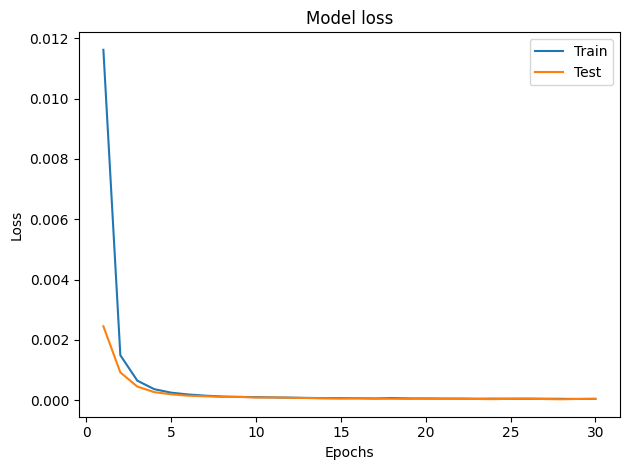

In [ ]:
displayLearningCurve(history=history_2R_raw, 
                    epochs=epochs_2R)

### II - 2D with 3 joints

### III - 3D with 5 joints

##### Saving models

In [ ]:
model_2R_raw.save(filepath=f'/models/NN1_2R_p{percentage_2R*100}_e{epochs_2R}.keras')
model_3R_raw.save(filepath=f'/models/NN1_3R_p{percentage_3R*100}_e{epochs_3R}.keras')
model_5R_raw.save(filepath=f'/models/NN1_5R_p{percentage_5R*100}_e{epochs_5R}.keras')